In [2]:
import numpy as np
from util import c_corners_within_radius as corners_within_radius

In [7]:
grid_spacing = np.array([0.5,0.5,0.5])
origin_crd = np.array([0.,0.,0.])
grid_counts = np.array([50,50,50])

In [8]:
grid_x = np.linspace(
        origin_crd[0],
        origin_crd[0] + ((grid_counts[0]-1) * grid_spacing[0]),
        num=grid_counts[0]
    )
grid_y = np.linspace(
    origin_crd[1],
    origin_crd[1] + ((grid_counts[1] - 1) * grid_spacing[1]),
    num=grid_counts[1]
)
grid_z = np.linspace(
    origin_crd[2],
    origin_crd[2] + ((grid_counts[2] - 1) * grid_spacing[2]),
    num=grid_counts[2]
)

i_max = grid_x.shape[0]
j_max = grid_y.shape[0]
k_max = grid_z.shape[0]

In [127]:
grid_tmp = np.empty([i_max, j_max, k_max], dtype=float)
atom_coordinate = np.array([i_max/2,j_max/2,k_max/2])*grid_spacing
uper_most_corner = np.array([i_max,j_max,k_max])
uper_most_corner_crd = uper_most_corner*grid_spacing
    
lj_diameter = 12
exponent = 0.5
charge = 10000.

dx2 = (atom_coordinate[0] - grid_x)**2
dy2 = (atom_coordinate[1] - grid_y)**2
dz2 = (atom_coordinate[2] - grid_z)**2

for i in range(i_max):
    dx_tmp = dx2[i]
    for j in range(j_max):
        dy_tmp = dy2[j]
        for k in range(k_max):

            d = dx_tmp + dy_tmp + dz2[k]
            d = d**exponent
            if d != 0:
                grid_tmp[i,j,k] = charge / d
            else:
                grid_tmp[i,j,k] = charge

corners = corners_within_radius(atom_coordinate, lj_diameter, origin_crd, uper_most_corner_crd,
                                    uper_most_corner, grid_spacing, grid_x, grid_y, grid_z, grid_counts)


for i, j, k in corners:
    grid_tmp[i,j,k] = 0

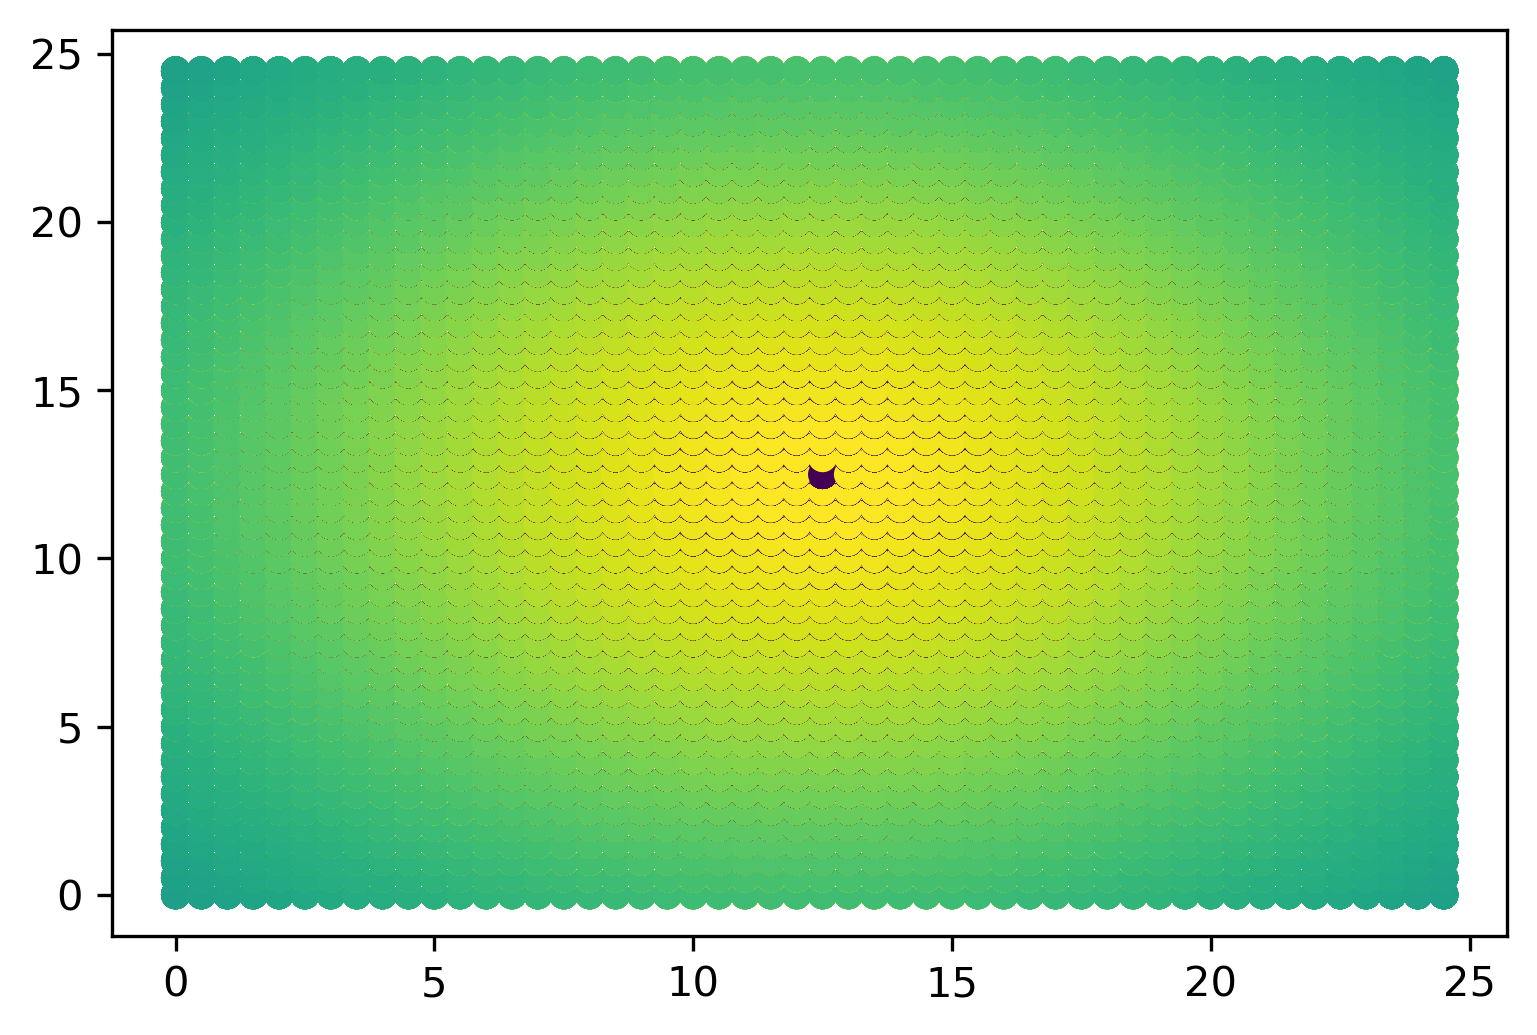

In [128]:
import matplotlib.pyplot as plt

# grid_tmp[grid_tmp < 0.1] = 0.
fig = plt.figure(dpi=300)
# ax = fig.add_subplot(projection='3d')

# ax.view_init(30, 60)
# ax.scatter(grid_x_r, grid_y_r, grid_z_r, c=grid_tmp)
plt.scatter(grid_x_r, grid_z_r, c=grid_tmp)

In [72]:
grid_x_r = np.tile(grid_x, (1,grid_counts[1],grid_counts[2]))
# grid_x_r = np.tile(grid_x_r, (1,grid_counts[2]))
# grid_y_r = np.tile(grid_y, (1,grid_counts[0]*grid_counts[2]))
# grid_y_r = np.repeat(grid_y, grid_counts[0]*grid_counts[2])
grid_z_r = np.repeat(grid_z, grid_counts[0]*grid_counts[1])
grid_y_r = np.tile(grid_y, (1,grid_counts[1],grid_counts[2]))
# grid_z_r = np.tile(grid_z, (1,grid_counts[1],grid_counts[2]))

In [73]:
grid_x_r.shape

(1, 50, 2500)

In [ ]:
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)